<a href="https://colab.research.google.com/github/Mario-U-KY/DataScience/blob/main/CLIP_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-w28b_oxq
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-w28b_oxq
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=68c73b0cd24b653f8dcba2184931466559b26795f2e5a5b367636c2bd774edbf
  Stored in directory: /tmp/pip-ephem-wheel-cache-glphz2qu/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [36]:
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
from torchvision import transforms

데이터 셋으로 kaggle의 beauty-dectection data를 불러왔다. 데이터 작성자가 모델과 연예인의 얼굴사진을 불러와서, 아무리 생각해도 일반인 수준의 외모가 아니면 beautiful, 그렇지 않으면 average로(데이터 제작자 기준) labeling을 한 이미지 데이터 셋이다. Clip에서 여러 이미지와 text 데이터로 학습을 한 만큼, 과연 Zero-shot으로 돌렸을 때, 이러한 부분을 분류해 낼 수 있을지 궁금했다. https://www.kaggle.com/datasets/gpiosenka/beauty-detection-data-set

In [5]:
data = pd.read_csv("/content/class_dict.csv")
data

,class_index,class,height,width,scale by
0,0,average,224,224,1
1,1,beautiful,224,224,1


In [75]:
!rmdir /content/test/.ipynb_checkpoints 

In [76]:
testset = torchvision.datasets.ImageFolder(root = "/content/test", transform = None)

In [47]:
for_image = torchvision.datasets.ImageFolder(root = "/content/test", transform = transforms.ToTensor())

In [48]:
ImageLoader = DataLoader(for_image,
                         batch_size=16,
                         shuffle = True,)

dataiter = iter(ImageLoader)
images, labels = dataiter.next()

In [49]:
labels

tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

In [50]:
def imshow(img):
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1,2,0)))

  print(np_img.shape)
  print((np.transpose(np_img,(1,2,0))).shape)

In [51]:
classes = testset.classes

torch.Size([16, 3, 224, 224])
(3, 906, 906)
(906, 906, 3)
torch.Size([16, 3, 224, 224])
torch.Size([3, 454, 1810])
average 
beautiful 
beautiful 
beautiful 

average 
average 
average 
average 

beautiful 
average 
beautiful 
average 

beautiful 
average 
average 
beautiful 



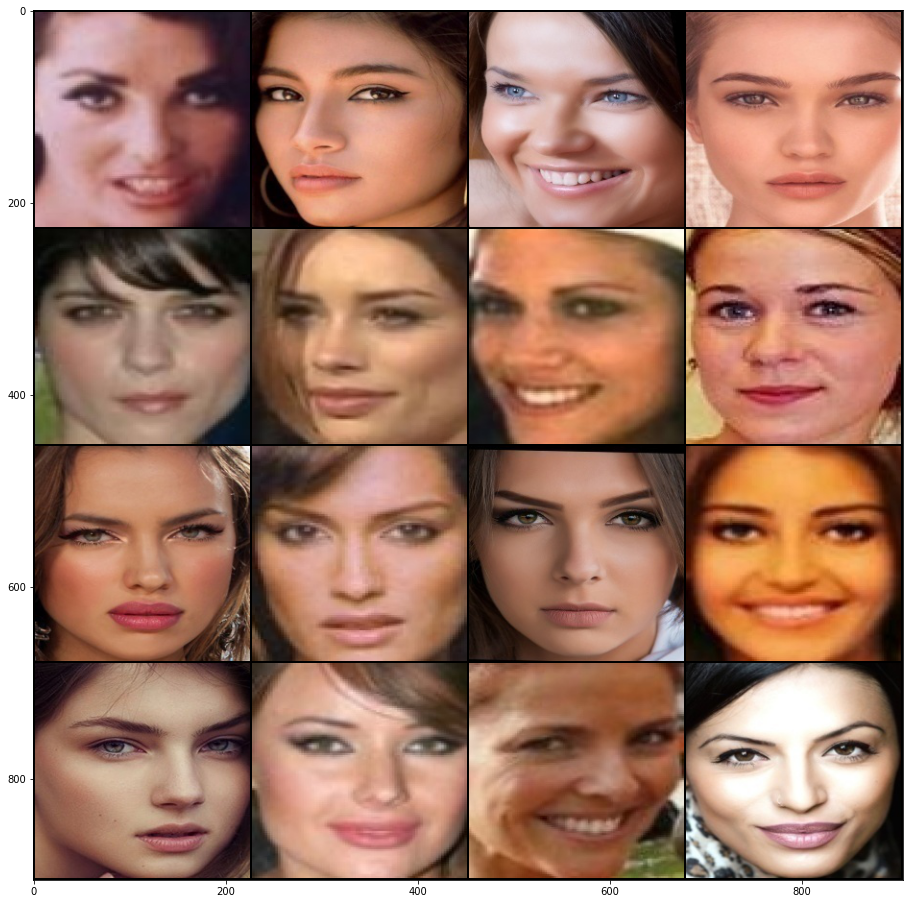

In [57]:
print(images.shape)
plt.figure(figsize=(16,16))
imshow(torchvision.utils.make_grid(images, nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
for j in range(16):
  print("".join("%5s "%classes[labels[j]]))
  if (j+1)%4==0:
    print('')

In [77]:
#Test용 코드
import os
import clip
import torch
from sklearn.metrics import accuracy_score

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

#accuracy lists
pred = []
true = []

# Prepare the inputs
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in testset.classes]).to(device)
image, class_id = testset[0]
image_input = preprocess(image).unsqueeze(0).to(device)

  # Calculate features
with torch.no_grad():
  image_features = model.encode_image(image_input)
  text_features = model.encode_text(text_inputs)

  # Pick the top 5 most similar labels for the image
  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
  values, indices = similarity[0].topk(2)

  # Print the result
  print("\nTop predictions:\n")

  switch=True
  for value, index in zip(values, indices):
      if switch==True: 
        pred.append(testset.classes[index])
        switch=False
      print(f"{testset.classes[index]:>16s}: {100 * value.item():.2f}%")
  print(f'{testset.classes[class_id]:>16s}')
  true.append(testset.classes[class_id])
accuracy_score(true, pred)




Top predictions:

         average: 59.28%
       beautiful: 40.72%
         average


1.0

In [24]:
import os
import clip
import torch
from torchvision import datasets
from sklearn.metrics import accuracy_score

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
#accuracy lists
pred = []
true = []
# Prepare the inputs
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in testset.classes]).to(device)
for i in range(len(testset)):
  image, class_id = testset[i]
  image_input = preprocess(image).unsqueeze(0).to(device)

  # Calculate features
  with torch.no_grad():
      image_features = model.encode_image(image_input)
      text_features = model.encode_text(text_inputs)

  # Pick the top 5 most similar labels for the image
  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
  values, indices = similarity[0].topk(2)

  # Print the result
  print("\nTop predictions:\n")

  switch=True
  for value, index in zip(values, indices):
      if switch==True: 
        pred.append(testset.classes[index])
        switch=False
      print(f"{testset.classes[index]:>16s}: {100 * value.item():.2f}%")
  print(f'{testset.classes[class_id]:>16s}')
  true.append(testset.classes[class_id])
accuracy_score(true, pred)


Top predictions:

         average: 59.28%
       beautiful: 40.72%
         average

Top predictions:

         average: 77.73%
       beautiful: 22.27%
         average

Top predictions:

         average: 58.89%
       beautiful: 41.11%
         average

Top predictions:

         average: 58.15%
       beautiful: 41.87%
         average

Top predictions:

         average: 62.26%
       beautiful: 37.74%
         average

Top predictions:

         average: 73.10%
       beautiful: 26.90%
         average

Top predictions:

         average: 84.18%
       beautiful: 15.82%
         average

Top predictions:

         average: 56.59%
       beautiful: 43.41%
         average

Top predictions:

         average: 74.02%
       beautiful: 25.98%
         average

Top predictions:

         average: 78.52%
       beautiful: 21.47%
         average

Top predictions:

         average: 63.72%
       beautiful: 36.30%
         average

Top predictions:

         average: 74.02%
       bea

0.82

놀랍게도 0.82의 정확도로 beautiful 여부를 맞추었다... ㅁㅊ

Logistic 적용은 굳이 필요해 보이지 않아서 진행하지 않았고, prompt를 수정해 보기로 했다.

A photo of a beautiful/average woman 으로 수정해 보았음.

In [58]:
import os
import clip
import torch
from torchvision import datasets
from sklearn.metrics import accuracy_score

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
#accuracy lists
pred = []
true = []
# Prepare the inputs
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c} woman") for c in testset.classes]).to(device)
for i in range(len(testset)):
  image, class_id = testset[i]
  image_input = preprocess(image).unsqueeze(0).to(device)

  # Calculate features
  with torch.no_grad():
      image_features = model.encode_image(image_input)
      text_features = model.encode_text(text_inputs)

  # Pick the top 5 most similar labels for the image
  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
  values, indices = similarity[0].topk(2)

  # Print the result
  print("\nTop predictions:\n")

  switch=True
  for value, index in zip(values, indices):
      if switch==True: 
        pred.append(testset.classes[index])
        switch=False
      print(f"{testset.classes[index]:>16s}: {100 * value.item():.2f}%")
  print(f'{testset.classes[class_id]:>16s}')
  true.append(testset.classes[class_id])
accuracy_score(true, pred)


Top predictions:

         average: 67.58%
       beautiful: 32.42%
         average

Top predictions:

         average: 64.79%
       beautiful: 35.23%
         average

Top predictions:

         average: 53.91%
       beautiful: 46.09%
         average

Top predictions:

       beautiful: 58.15%
         average: 41.87%
         average

Top predictions:

       beautiful: 56.59%
         average: 43.41%
         average

Top predictions:

       beautiful: 53.12%
         average: 46.88%
         average

Top predictions:

         average: 78.81%
       beautiful: 21.20%
         average

Top predictions:

       beautiful: 57.76%
         average: 42.26%
         average

Top predictions:

         average: 61.87%
       beautiful: 38.11%
         average

Top predictions:

         average: 50.39%
       beautiful: 49.61%
         average

Top predictions:

         average: 57.37%
       beautiful: 42.63%
         average

Top predictions:

         average: 69.58%
       bea

0.7233333333333334

오히려 정확도가 더 떨어졌다. 

라벨링을 pretty, average로 바꾸면 어떨까? 폴더명을 pretty로 변경 후 다시 시도해 보았다.

In [60]:
!rmdir /content/test/.ipynb_checkpoints 

In [61]:
testset = torchvision.datasets.ImageFolder(root = "/content/test", transform = None)

In [62]:
import os
import clip
import torch
from torchvision import datasets
from sklearn.metrics import accuracy_score

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
#accuracy lists
pred = []
true = []
# Prepare the inputs
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in testset.classes]).to(device)
for i in range(len(testset)):
  image, class_id = testset[i]
  image_input = preprocess(image).unsqueeze(0).to(device)

  # Calculate features
  with torch.no_grad():
      image_features = model.encode_image(image_input)
      text_features = model.encode_text(text_inputs)

  # Pick the top 5 most similar labels for the image
  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
  values, indices = similarity[0].topk(2)

  # Print the result
  print("\nTop predictions:\n")

  switch=True
  for value, index in zip(values, indices):
      if switch==True: 
        pred.append(testset.classes[index])
        switch=False
      print(f"{testset.classes[index]:>16s}: {100 * value.item():.2f}%")
  print(f'{testset.classes[class_id]:>16s}')
  true.append(testset.classes[class_id])
accuracy_score(true, pred)


Top predictions:

         average: 67.92%
          pretty: 32.08%
         average

Top predictions:

         average: 79.05%
          pretty: 20.95%
         average

Top predictions:

          pretty: 51.17%
         average: 48.83%
         average

Top predictions:

         average: 61.52%
          pretty: 38.50%
         average

Top predictions:

          pretty: 53.91%
         average: 46.09%
         average

Top predictions:

         average: 63.72%
          pretty: 36.30%
         average

Top predictions:

         average: 84.57%
          pretty: 15.41%
         average

Top predictions:

         average: 62.26%
          pretty: 37.74%
         average

Top predictions:

         average: 86.52%
          pretty: 13.48%
         average

Top predictions:

         average: 80.08%
          pretty: 19.93%
         average

Top predictions:

         average: 66.55%
          pretty: 33.45%
         average

Top predictions:

         average: 78.27%
          

0.85

더 정확도가 올라갔다. 

이번엔 celebritiy로 단어를 바꾸어 보았다.

In [63]:
!rmdir /content/test/.ipynb_checkpoints 

In [64]:
testset = torchvision.datasets.ImageFolder(root = "/content/test", transform = None)

In [65]:
import os
import clip
import torch
from torchvision import datasets
from sklearn.metrics import accuracy_score

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
#accuracy lists
pred = []
true = []
# Prepare the inputs
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in testset.classes]).to(device)
for i in range(len(testset)):
  image, class_id = testset[i]
  image_input = preprocess(image).unsqueeze(0).to(device)

  # Calculate features
  with torch.no_grad():
      image_features = model.encode_image(image_input)
      text_features = model.encode_text(text_inputs)

  # Pick the top 5 most similar labels for the image
  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
  values, indices = similarity[0].topk(2)

  # Print the result
  print("\nTop predictions:\n")

  switch=True
  for value, index in zip(values, indices):
      if switch==True: 
        pred.append(testset.classes[index])
        switch=False
      print(f"{testset.classes[index]:>16s}: {100 * value.item():.2f}%")
  print(f'{testset.classes[class_id]:>16s}')
  true.append(testset.classes[class_id])
accuracy_score(true, pred)


Top predictions:

       celebrity: 65.14%
         average: 34.86%
         average

Top predictions:

       celebrity: 60.74%
         average: 39.23%
         average

Top predictions:

       celebrity: 74.90%
         average: 25.10%
         average

Top predictions:

       celebrity: 80.08%
         average: 19.93%
         average

Top predictions:

         average: 56.98%
       celebrity: 43.02%
         average

Top predictions:

       celebrity: 74.02%
         average: 25.98%
         average

Top predictions:

         average: 69.92%
       celebrity: 30.08%
         average

Top predictions:

       celebrity: 74.02%
         average: 25.98%
         average

Top predictions:

         average: 55.47%
       celebrity: 44.56%
         average

Top predictions:

       celebrity: 56.59%
         average: 43.41%
         average

Top predictions:

       celebrity: 55.47%
         average: 44.56%
         average

Top predictions:

         average: 58.15%
       cel

0.24333333333333335

이번엔 normal pretty로 돌려 보았다.

In [66]:
!rmdir /content/test/.ipynb_checkpoints 

In [67]:
testset = torchvision.datasets.ImageFolder(root = "/content/test", transform = None)

In [68]:
import os
import clip
import torch
from torchvision import datasets
from sklearn.metrics import accuracy_score

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
#accuracy lists
pred = []
true = []
# Prepare the inputs
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in testset.classes]).to(device)
for i in range(len(testset)):
  image, class_id = testset[i]
  image_input = preprocess(image).unsqueeze(0).to(device)

  # Calculate features
  with torch.no_grad():
      image_features = model.encode_image(image_input)
      text_features = model.encode_text(text_inputs)

  # Pick the top 5 most similar labels for the image
  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
  values, indices = similarity[0].topk(2)

  # Print the result
  print("\nTop predictions:\n")

  switch=True
  for value, index in zip(values, indices):
      if switch==True: 
        pred.append(testset.classes[index])
        switch=False
      print(f"{testset.classes[index]:>16s}: {100 * value.item():.2f}%")
  print(f'{testset.classes[class_id]:>16s}')
  true.append(testset.classes[class_id])
accuracy_score(true, pred)


Top predictions:

          normal: 53.12%
          pretty: 46.88%
          normal

Top predictions:

          normal: 53.12%
          pretty: 46.88%
          normal

Top predictions:

          pretty: 70.90%
          normal: 29.10%
          normal

Top predictions:

          normal: 50.39%
          pretty: 49.61%
          normal

Top predictions:

          pretty: 86.52%
          normal: 13.48%
          normal

Top predictions:

          pretty: 55.08%
          normal: 44.95%
          normal

Top predictions:

          normal: 68.26%
          pretty: 31.74%
          normal

Top predictions:

          normal: 51.17%
          pretty: 48.83%
          normal

Top predictions:

          normal: 77.44%
          pretty: 22.55%
          normal

Top predictions:

          normal: 50.39%
          pretty: 49.61%
          normal

Top predictions:

          normal: 61.52%
          pretty: 38.50%
          normal

Top predictions:

          normal: 66.89%
          

0.7633333333333333

이번엔 ugly pretty로 돌려 보았다.

In [70]:
!rmdir /content/test/.ipynb_checkpoints 

In [71]:
testset = torchvision.datasets.ImageFolder(root = "/content/test", transform = None)

In [72]:
import os
import clip
import torch
from torchvision import datasets
from sklearn.metrics import accuracy_score

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
#accuracy lists
pred = []
true = []
# Prepare the inputs
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in testset.classes]).to(device)
for i in range(len(testset)):
  image, class_id = testset[i]
  image_input = preprocess(image).unsqueeze(0).to(device)

  # Calculate features
  with torch.no_grad():
      image_features = model.encode_image(image_input)
      text_features = model.encode_text(text_inputs)

  # Pick the top 5 most similar labels for the image
  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
  values, indices = similarity[0].topk(2)

  # Print the result
  print("\nTop predictions:\n")

  switch=True
  for value, index in zip(values, indices):
      if switch==True: 
        pred.append(testset.classes[index])
        switch=False
      print(f"{testset.classes[index]:>16s}: {100 * value.item():.2f}%")
  print(f'{testset.classes[class_id]:>16s}')
  true.append(testset.classes[class_id])
accuracy_score(true, pred)


Top predictions:

          pretty: 85.40%
            ugly: 14.61%
          pretty

Top predictions:

          pretty: 83.35%
            ugly: 16.66%
          pretty

Top predictions:

          pretty: 95.85%
            ugly: 4.15%
          pretty

Top predictions:

          pretty: 75.20%
            ugly: 24.80%
          pretty

Top predictions:

          pretty: 83.35%
            ugly: 16.66%
          pretty

Top predictions:

          pretty: 84.18%
            ugly: 15.82%
          pretty

Top predictions:

          pretty: 87.74%
            ugly: 12.25%
          pretty

Top predictions:

          pretty: 98.39%
            ugly: 1.62%
          pretty

Top predictions:

          pretty: 71.53%
            ugly: 28.47%
          pretty

Top predictions:

          pretty: 67.24%
            ugly: 32.76%
          pretty

Top predictions:

          pretty: 88.09%
            ugly: 11.92%
          pretty

Top predictions:

          pretty: 89.31%
            

0.91

상대적인 단어로 배치하니 훨씬 성능이 좋았다.

인공지능, 윤리의 관점에서 Clip이 거론되는 이유를 조금 이해할 수 있었다. 
인터넷 상의 text, image로 부터 데이터를 수집하고 학습을 진행시켜 놔서 그런지, beautiful, average의 미묘한 차이를 분류해내듯, 성별 인종 직업 등에서 분명히 데이터의 격차로 만들어지는 bias가 존재할 것이 유추가 가능했다.